# Scrape and save 

In [1]:
import requests
from bs4 import BeautifulSoup
import re,json

In [2]:
class Categories():
    def __init__(self,target=None):
        self.target = target # either None or (id,name)
        self.website = 'https://www.browsenodes.com/amazon.com'
        self.level = 0 # category level; 0 level ones are the main root categories 
        self.edges = {self.level:[]} # level: (parent_id, child_id)
        self.id_to_name = {} 


        if target is None: # get the names of all the main categories (41 in total) 
            self.n = 4 # <name> <id> <name> <url> format for the home page 
            result = requests.get(self.website)
            content = result.text
            soup = BeautifulSoup(content, 'lxml')
            self.get_info(soup)
        elif len(target) == 2: # start from a child node 
            self.n = 3 # <name> <id> <url> format for all other subpages
            result = requests.get(self.get_url(self.target))
            if not re.search(r"^\d+$",target[0]):
                print("Error: please enter the category id as the first element of target.")
            else: 
                self.id_to_name[target[0]] = target[1]
                self.edges[0].append((None,self.target[0])) 
        else: 
            print("Error: please enter target in the right format.")
        # print(self.edges, self.id_to_name)

    def num_children(self):
        num = 0 
        for p,c in self.edges[self.level]:
            if c is not None: 
                num += 1 
        return num

    def get_url(self, category_id):
        return f"{self.website}/browseNodeLookup/{category_id}.html"

    def get_info(self,soup,parent_id=None):
        newlevel = self.level + 1 
        table = soup.find_all("td") # entries of the data table on the website page 
        if len(table) == 0: # no data 
            self.edges[newlevel].append((parent_id,None))
        elif "is a leaf node" in table[0].text: # reached a leaf node 
            self.edges[newlevel].append((parent_id,None))
        else:     # there exist children 
            curr_id, curr_name = None, None
            for idx, entry in enumerate(table): 
                t = entry.text
                t = re.sub(r"\s{2,}","",t)
                if (idx+1) % self.n == 1: 
                    curr_name = t
                elif (idx+1) % self.n == 2: 
                    curr_id = t 
                    if curr_id not in self.id_to_name:
                        self.id_to_name[curr_id] = curr_name
                    if parent_id is None: 
                        self.edges[0].append((None,curr_id))         
                    else: 
                        self.edges[newlevel].append((parent_id,curr_id))
                    curr_id, curr_name = None, None
    
    def process_descendents(self,filename):
        self.n = 3 
        while self.num_children() > 0:
            self.edges[self.level+1] = [] 
            for p,curr in self.edges[self.level]: 
                if curr is None: continue 
                link = self.get_url(curr)
                result = requests.get(link)
                content = result.text
                soup = BeautifulSoup(content, 'lxml')
                self.get_info(soup,curr)
                print(f"Processed level {self.level+1} children of {self.id_to_name[curr]} ({curr})")
                with open(f"../categories/{filename}","w+") as file: 
                    json.dump((self.edges,self.id_to_name),file)
            self.level += 1 

def process(parent_id, parent_name):
    categories = Categories((parent_id,parent_name))
    categories.process_descendents(f"{parent_name}.json")
    print(categories.edges, "\n", categories.id_to_name)

In [ ]:
parent_id = '7192394011'
parent_name = "Clothing, Shoes & Jewelry - Women - Jewelry"
process(parent_id, parent_name)

In [ ]:
parent_id = '3887881'
parent_name = "Clothing, Shoes & Jewelry - Men - Jewelry"
process(parent_id, parent_name)

In [ ]:
parent_id = '3880611'
parent_name = "Clothing, Shoes & Jewelry - Boys - Jewelry"
process(parent_id, parent_name)

In [69]:
parent_id = '3880961'
parent_name = "Clothing, Shoes & Jewelry - Girls - Jewelry"
process(parent_id, parent_name)

Processed level 1 children of Clothing, Shoes & Jewelry - Girls - Jewelry (3880961)
Processed level 2 children of Anklets (3881481)
Processed level 2 children of Bracelets (3881461)
Processed level 2 children of Brooches & Pins (3881551)
Processed level 2 children of Earrings (3881621)
Processed level 2 children of Necklaces & Pendants (3881811)
Processed level 2 children of Rings (3881961)
Processed level 3 children of Bangle (3881491)
Processed level 3 children of Charm (3881501)
Processed level 3 children of Cuff (3881511)
Processed level 3 children of Identification (3881521)
Processed level 3 children of Link (3881531)
Processed level 3 children of Ball (3881641)
Processed level 3 children of Drop & Dangle (3881661)
Processed level 3 children of Hoop (3881731)
Processed level 3 children of Stud (3881791)
Processed level 3 children of Chains (3881821)
Processed level 3 children of Lockets (3881831)
Processed level 3 children of Pendants (3881851)
{0: [(None, '3880961')], 1: [('3880

In [ ]:
parent_id = '5524110011'
parent_name = "Musical Instruments - Instrument Accessories - Orchestral Strings Accessories & Parts"
process(parent_id, parent_name)

# Combine and translate 

In [4]:
import os 
import json
import pandas as pd 
all_id_to_name = {}
levels = {}
for filepath in os.listdir(f"../categories"): 
    if "categories_graph.json" in filepath or ".csv" in filepath: continue
    filepath = f"../categories/{filepath}"
    with open(filepath,"r") as file: 
        edges,id_to_name = json.load(file)
    all_id_to_name.update(id_to_name)
    for level, edge_list in edges.items(): 
        for s,t in edge_list: 
            if t is not None:
                if level not in levels:  levels[level] = {}
                if s not in levels[level]: levels[level][s] = []
                levels[level][s].append(t)

# names =[{"name":v} for k,v in all_id_to_name.items()]
# df = pd.DataFrame(names)
# df.to_csv(f"../categories/names.csv")
with open(f"../categories/categories_graph.json","w+") as file:  
    json.dump(levels,file) 

In [3]:
complete_id_to_name = []
zh = pd.read_csv("../categories/translations.csv")
for idx, cat_id in enumerate(all_id_to_name):
    name = all_id_to_name[cat_id]
    trans = zh['name'][idx]
    complete_id_to_name.append({"id":cat_id,"name":name,"translation":trans})
df = pd.DataFrame(complete_id_to_name)
df.to_csv(f"../categories/ID_TO_NAME.csv")

# Visualizations + relevant category ids & paths  

In [5]:
import pandas as pd 
data = pd.read_csv(f"../data/ID_TO_NAME.csv")
all_id_to_name = {str(cat_id): data['name'][idx] for idx, cat_id in enumerate(data['id']) }

In [15]:
import networkx as nx 
import matplotlib.pyplot as plt 

def graph(filepath,figsize=(15,15),show=False):
  with open(filepath,"r") as file: 
      edges,id_to_name = json.load(file)
  G = nx.Graph() 
  for level, edgelist in edges.items(): 
    for e in edgelist: 
        if None in e: continue 
        i = (id_to_name[e[0]],e[0])
        j = (id_to_name[e[1]],e[1])
        G.add_edge(i,j) 

  if show: 
    plt.figure(figsize=figsize) 
    nx.draw(G,node_color="lightblue",with_labels=True) 
    plt.show() 
  return G, id_to_name

def find_node(target,id_to_name):
    targets = []
    for cat_id, name in id_to_name.items(): 
        if name == target:
            targets.append(cat_id)
    return targets  


def bfs(G, source, target):
    '''
    source: (name, id) 
    target: id  
    '''
    queue = []
    queue.append([source]) 
    while queue:
        path = queue.pop(0)
        node = path[-1]
        if target in node:  
            return path 
        for neighbor in nx.neighbors(G, node):
            new_path = list(path)
            new_path.append(neighbor)
            queue.append(new_path)
    return None 

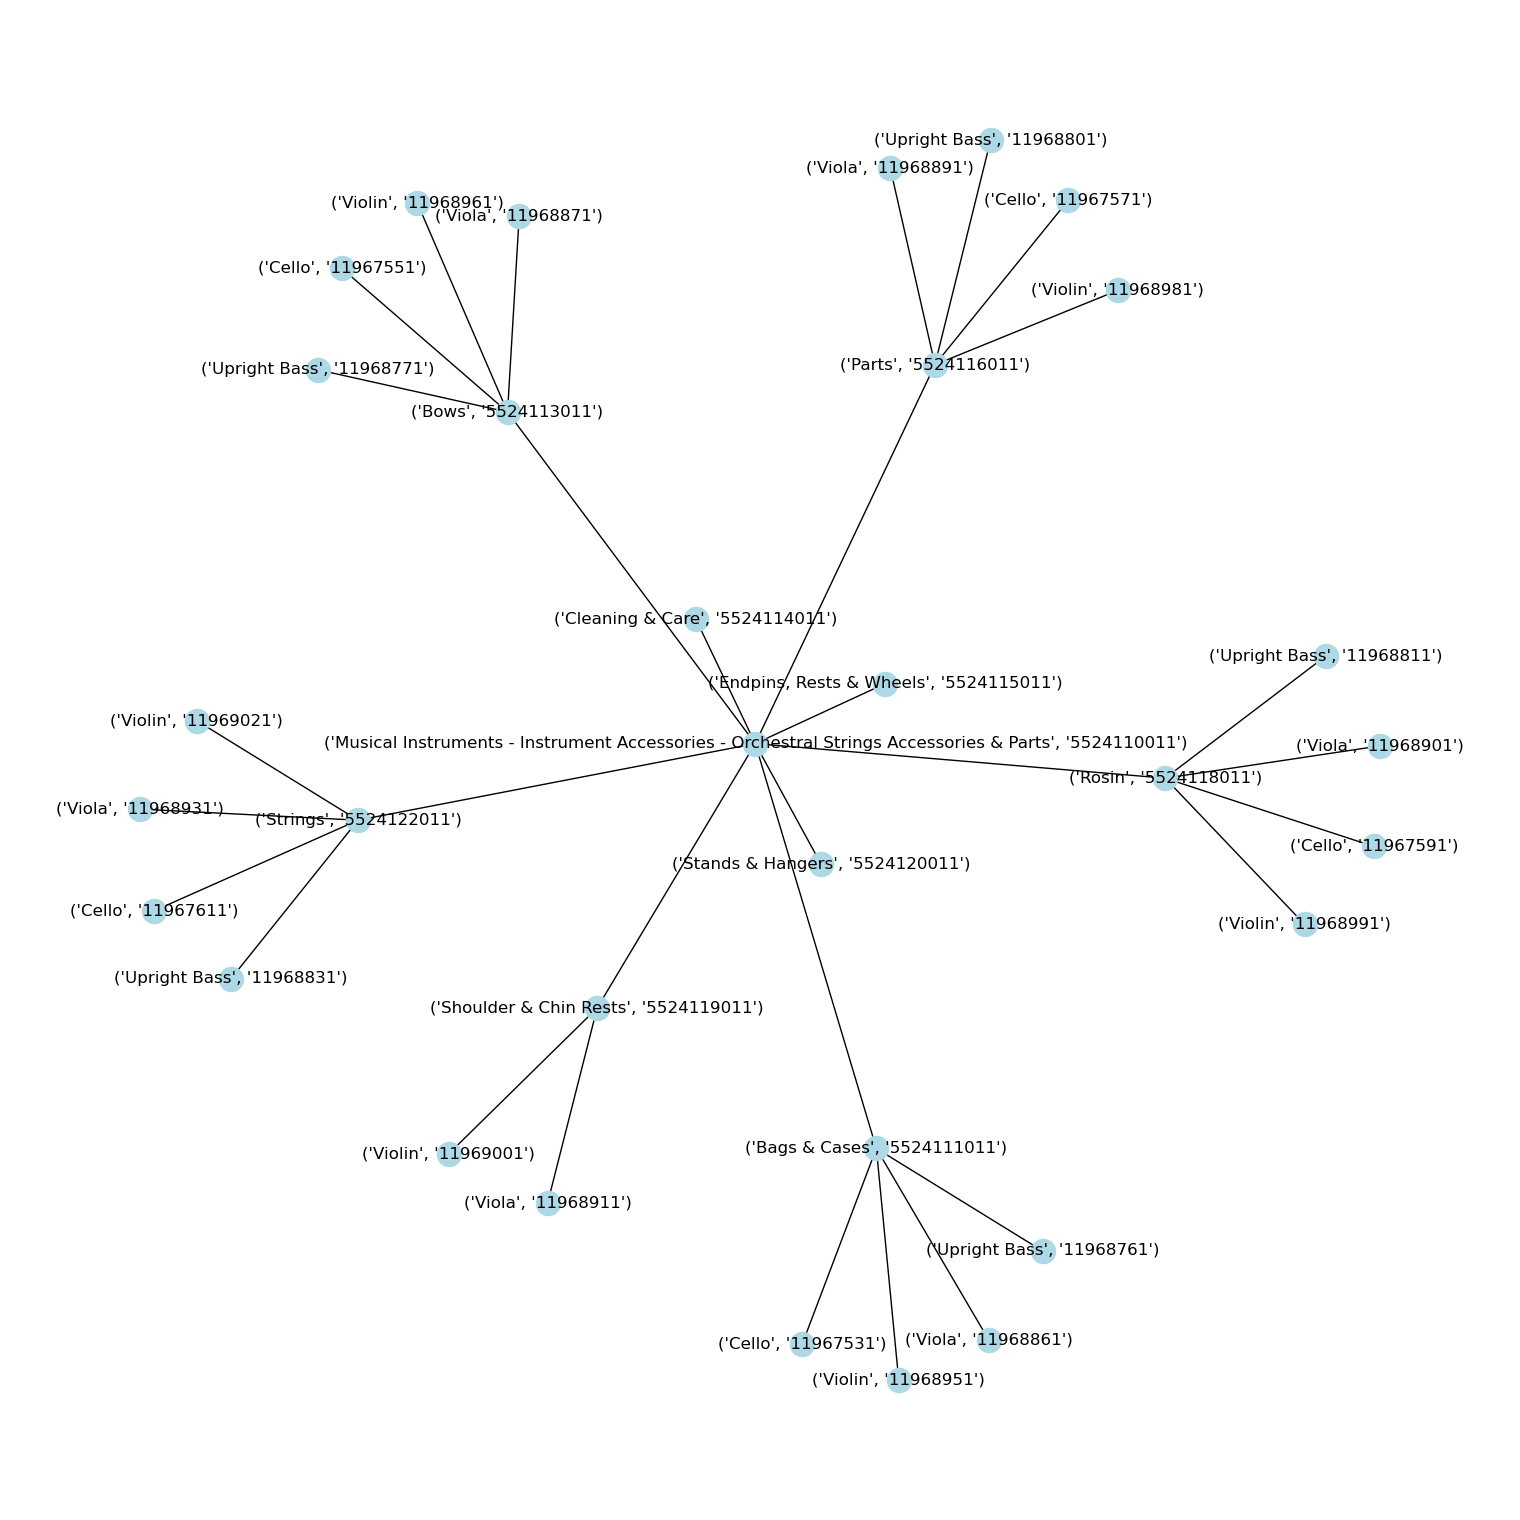

In [16]:
G, id_to_name = graph(f"../categories/{all_id_to_name['5524110011']}.json",show=True)

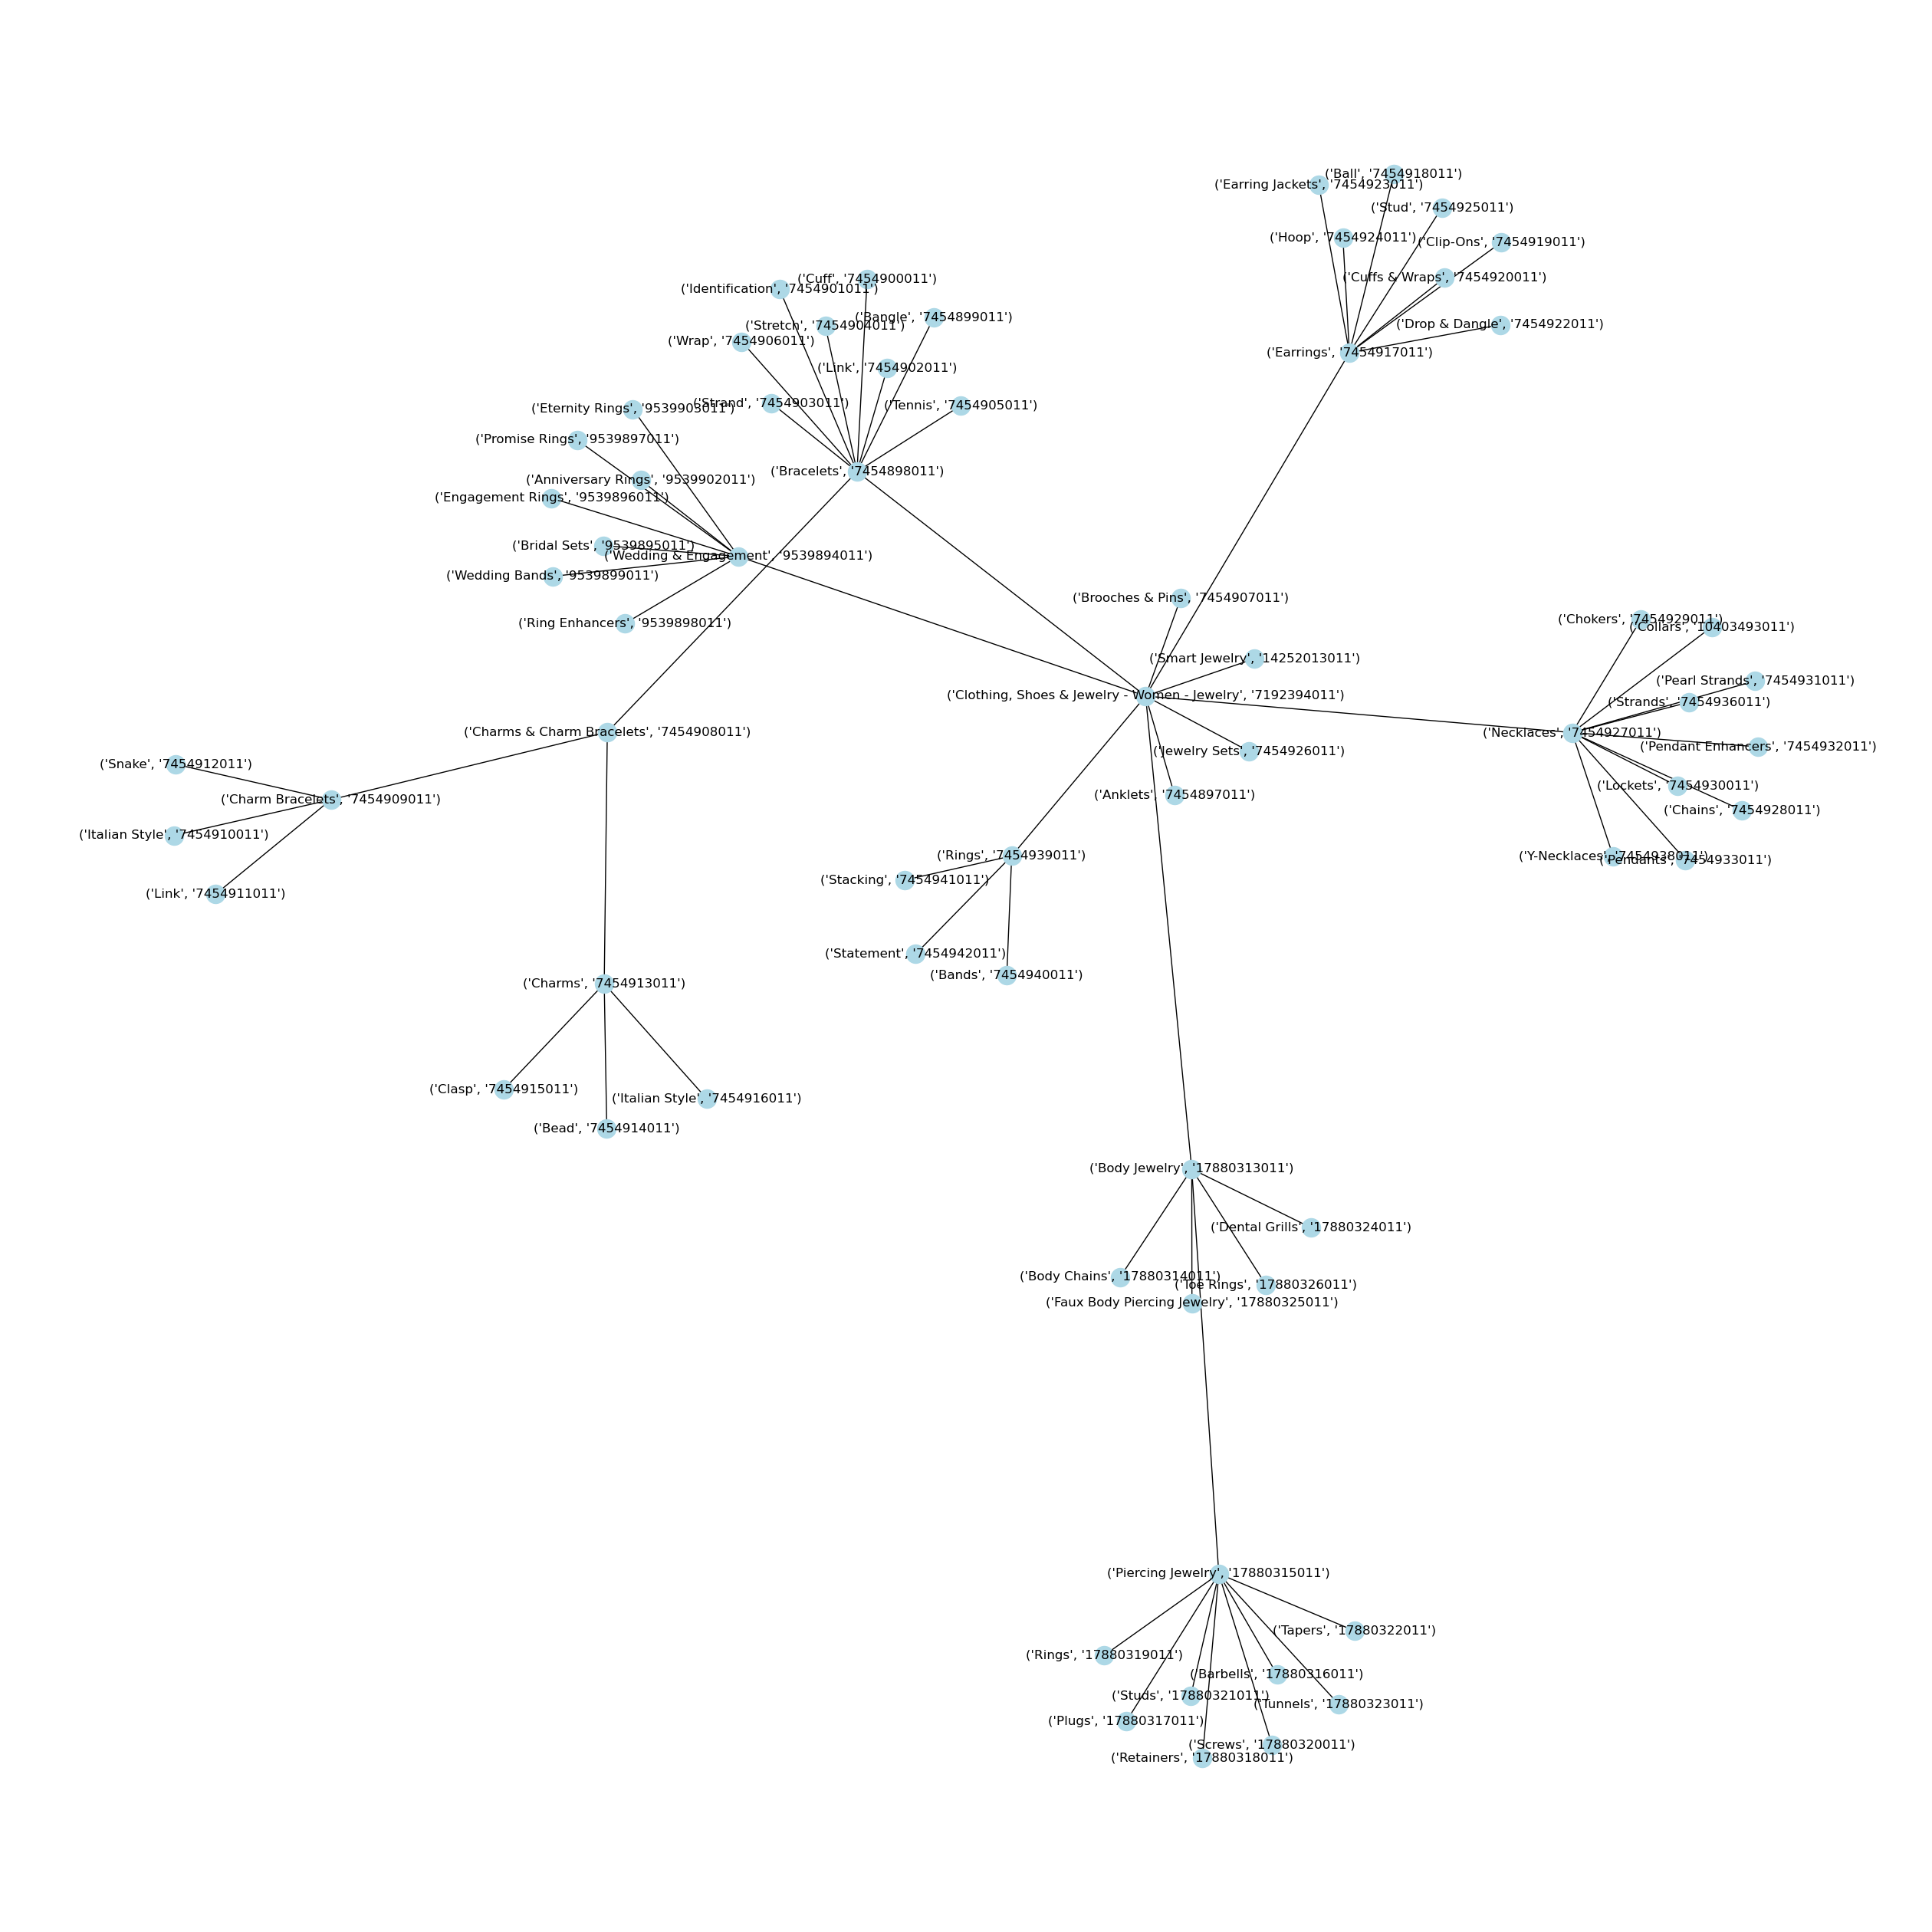

In [25]:
G, id_to_name = graph(f"../categories/{all_id_to_name['7192394011']}.json",figsize=(25,25),show=True)

In [29]:
def find_paths(source,keyword):
    G, id_to_name = graph(f"../categories/{all_id_to_name[source]}.json")
    root = (id_to_name[source],source)
    targets = find_node(keyword,id_to_name)
    paths = {}
    for cat_id in targets: 
        path = bfs(G, root, cat_id)
        print(path,"\n")
        final = path[-1]
        paths[final[-1]] = path
    return targets, paths


targets, paths =  find_paths('5524110011','Violin')
with open(f"../data/categories/Violin.json","w+") as file: 
    json.dump((targets,paths),file)

[('Musical Instruments - Instrument Accessories - Orchestral Strings Accessories & Parts', '5524110011'), ('Bags & Cases', '5524111011'), ('Violin', '11968951')] 

[('Musical Instruments - Instrument Accessories - Orchestral Strings Accessories & Parts', '5524110011'), ('Bows', '5524113011'), ('Violin', '11968961')] 

[('Musical Instruments - Instrument Accessories - Orchestral Strings Accessories & Parts', '5524110011'), ('Parts', '5524116011'), ('Violin', '11968981')] 

[('Musical Instruments - Instrument Accessories - Orchestral Strings Accessories & Parts', '5524110011'), ('Rosin', '5524118011'), ('Violin', '11968991')] 

[('Musical Instruments - Instrument Accessories - Orchestral Strings Accessories & Parts', '5524110011'), ('Shoulder & Chin Rests', '5524119011'), ('Violin', '11969001')] 

[('Musical Instruments - Instrument Accessories - Orchestral Strings Accessories & Parts', '5524110011'), ('Strings', '5524122011'), ('Violin', '11969021')] 



In [32]:
sources =  ['7192394011','3887881','3880961','3880611']
keywords = ['Bracelets','Necklaces','Rings','Anklets','Earrings',
           'Brooches & Pins','Necklaces & Pendants',
           'Wedding & Engagement','Body Jewelry','Jewelry Sets']

search_ids = []
search_paths = {}
for s in sources: 
    for k in keywords: 
        targets, paths = find_paths(s,k)
        search_ids.extend(targets)
        search_paths.update(paths)

with open(f"../data/categories/Jewelry.json","w+") as file: 
    json.dump((search_ids,search_paths),file)

[('Clothing, Shoes & Jewelry - Women - Jewelry', '7192394011'), ('Bracelets', '7454898011')] 

[('Clothing, Shoes & Jewelry - Women - Jewelry', '7192394011'), ('Necklaces', '7454927011')] 

[('Clothing, Shoes & Jewelry - Women - Jewelry', '7192394011'), ('Rings', '7454939011')] 

[('Clothing, Shoes & Jewelry - Women - Jewelry', '7192394011'), ('Body Jewelry', '17880313011'), ('Piercing Jewelry', '17880315011'), ('Rings', '17880319011')] 

[('Clothing, Shoes & Jewelry - Women - Jewelry', '7192394011'), ('Anklets', '7454897011')] 

[('Clothing, Shoes & Jewelry - Women - Jewelry', '7192394011'), ('Earrings', '7454917011')] 

[('Clothing, Shoes & Jewelry - Women - Jewelry', '7192394011'), ('Brooches & Pins', '7454907011')] 

[('Clothing, Shoes & Jewelry - Women - Jewelry', '7192394011'), ('Wedding & Engagement', '9539894011')] 

[('Clothing, Shoes & Jewelry - Women - Jewelry', '7192394011'), ('Body Jewelry', '17880313011')] 

[('Clothing, Shoes & Jewelry - Women - Jewelry', '7192394011'), 

In [8]:
import os,json
search_ids =  []
for filepath in os.listdir(f"../data/categories"): 
    filepath = f"../data/categories/{filepath}"
    with open(filepath,"r") as file: 
        ids,paths = json.load(file)
search_ids.extend(ids)
with open(f"search_ids.json","w+") as file: 
    json.dump(search_ids,file)